In [12]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import OrderedDict
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
%matplotlib inline
torch.manual_seed(37)

In [13]:
class cfg_train:
    data_dir = '/opt/ml/input/data/train'
    img_dir = 'images'
    df_path = 'train.csv'
class cfg_test:
    data_dir = '/opt/ml/input/data/eval'
    img_dir = 'images'
    df_path = 'info.csv'

In [14]:
class CustomDataset(Dataset):
    def __init__(self, path, df_path, train=True, transform = None):
        self.path = path
        self.transform = transform
        self.train = train
        if self.train == True:
            self.df = pd.read_csv(os.path.join(self.path, df_path)).drop(['id','race'], axis=1)
            self.DF = self._getlabel(os.path.join(self.path, 'images'), self.df.values)
            self.X = self.DF['ImageID'].values
            self.y = self.DF['ans'].values
            self.DF.to_csv(path_or_buf = os.path.join(self.path,"labeling.csv"), index=False)
        else:
            self.df = pd.read_csv(os.path.join(self.path, df_path)).drop('ans', axis=1)
            self.X = self.df.values.squeeze()
            self.X = np.array(list(map(lambda x: os.path.join(self.path, cfg_test.img_dir, x), self.X)))


    def __len__(self):
        len_dataset = len(self.X)
        return len_dataset

    def _concats(self, concats):
        self.concats = []
        self.concats.append(self.DF)
        for concat in concats:
            self.concats.append(concat)
        self.DF = pd.concat(self.concats)
        self.X = self.DF['ImageID'].values
        self.y = self.DF['ans'].values
        

    def __getitem__(self, idx):
        if self.train == True:
            img = cv2.imread(self.X[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(image=img)["image"]
            y = self.y[idx]
            return img, y
        else:
            img = Image.open(self.X[idx])
            if self.transform:
                img = self.transform(img)
            return img

    def _getlabel(self, img_dir, data):
        self.direc=[]
        y=[]
        for row in tqdm(data):
            for path in glob(os.path.join(img_dir,row[2],'*')):
                self.direc.append(np.concatenate((row, np.reshape(path,1)),axis=0))
        mask_pd = pd.DataFrame(self.direc, columns = ['gender','age','person','path']).drop('person',axis=1)
        for gender, age, path in mask_pd.values:
            temp_class=0
            if 'incorrect' in path:
                temp_class+=6
            if 'normal' in path:
                temp_class+=12
            if gender == 'female':
                temp_class+=3
            if age >= 30 and age < 60:
                temp_class+=1
            if age >= 60:
                temp_class+=2
            y.append(temp_class)
        return pd.concat([mask_pd['path'], pd.Series(data=y,name = 'ans')],axis=1).rename(columns={'path':'ImageID'})

#if __name__ == "__main__":
#    mask_train = CustomDataset(cfg.data_dir,["id",'race'],train=True, transform = torchvision.transforms.ToTensor())

In [15]:
train_transform_RGB = A.Compose([
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
    A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246), max_pixel_value=255.0, always_apply=False, p=1.0),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
    ToTensorV2()
])
train_transform_flip = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
    ToTensorV2()
])
train_transform_vanilla = A.Compose([
    A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

mask_train_RGB = CustomDataset(cfg_train.data_dir,'train.csv', train = True, transform = train_transform_RGB)
mask_train_flip = CustomDataset(cfg_train.data_dir,'train.csv', train = True, transform = train_transform_flip)
mask_train = CustomDataset(cfg_train.data_dir,'train.csv', train = True, transform = train_transform_vanilla)
mask_train._concats([mask_train_RGB.DF, mask_train_flip.DF])

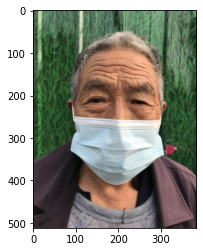

In [16]:
mask_test = CustomDataset(cfg_test.data_dir,'info.csv', train = False)
plt.imshow(mask_test[1])
mask_test = CustomDataset(cfg_test.data_dir,'info.csv', train = False, transform = torchvision.transforms.ToTensor())

In [17]:
BATCH_SIZE = 64
val_size = len(mask_train)//5
train_size = len(mask_train)-val_size
test_dataloader = torch.utils.data.DataLoader(mask_test, batch_size = BATCH_SIZE, shuffle = False)
train_dataset, val_dataset = torch.utils.data.random_split(mask_train, [train_size,val_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
dataloaders = {
    "train" : train_dataloader,
    "test" : val_dataloader,
    "eval" : test_dataloader
}

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import math

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.add_model = nn.Sequential(OrderedDict([
            ('my_conv1', nn.Conv2d(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('batch', nn.BatchNorm2d(1024, eps = 1e-05, momentum = 0.1, affine=True, track_running_stats = True)),
            ('drop', nn.Dropout(p=0.5, inplace=True)),
            ('relu', nn.ReLU(inplace = True)),
            ('my_conv2', nn.Conv2d(1024, 2048, kernel_size = (3,3), stride=(1,1), padding=(1,1), bias = False)),
            ('batch2', nn.BatchNorm2d(2048, eps = 1e-05, momentum = 0.1, affine=True, track_running_stats = True)),
            ('relu2', nn.ReLU(inplace = True))
        ]))
        self.fc_model = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(in_features = 2048, out_features = 18, bias = True))
        ]))
        self.pretrained =torchvision.models.resnet50(pretrained=True)
        self.pretrained = nn.Sequential(*list(self.pretrained.children())[:-2])
        self.my_model = nn.Sequential(
            self.pretrained,
            self.add_model,
            self.add_model,
            self.fc_model
        )
        for name, layer in self.my_model[1:3].named_modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
        for name, layer in self.my_model[3].named_modules():
            if isinstance(layer, nn.Linear):
                print(layer.weight)
                nn.init.xavier_uniform_(layer.weight)
                stdv = 1./math.sqrt(layer.weight.size(1))
                layer.bias.data.uniform_(-stdv, stdv)
        print(self.my_model)
    
    def forward(self, x):
        x = self.my_model[0](x)
        x = self.my_model[1](x)
        x = self.my_model[2](x)
        x = nn.AdaptiveAvgPool2d(output_size = (1,1))(x)
        x = x.view(-1,2048)
        x = self.my_model[3](x)
        return x

In [19]:
myModel = MyModule()

Parameter containing:
tensor([[-0.0134,  0.0190,  0.0203,  ...,  0.0022,  0.0181, -0.0123],
        [-0.0055, -0.0128, -0.0184,  ..., -0.0119, -0.0085,  0.0122],
        [-0.0008,  0.0219,  0.0176,  ...,  0.0076,  0.0066, -0.0042],
        ...,
        [-0.0023, -0.0081, -0.0209,  ..., -0.0085, -0.0136,  0.0134],
        [ 0.0072, -0.0066,  0.0106,  ..., -0.0134, -0.0058, -0.0165],
        [-0.0218, -0.0118,  0.0116,  ...,  0.0123, -0.0093,  0.0097]],
       requires_grad=True)
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is using")
myModel.to(device)
LEARNING_RATE = 0.0001
NUM_EPOCH = 1000

loss_fn = torch.nn.CrossEntropyLoss()
for parameter in myModel.parameters():
    parameter.requires_grad = False
for parameter in myModel.my_model[1:3].parameters():
    parameter.requires_grad = True
optimizer = torch.optim.Adam(myModel.parameters(), lr = LEARNING_RATE)

cuda:0 is using


In [21]:
ckpt_dir = os.path.join(cfg_test.data_dir, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  


In [22]:
best_test_accuracy = 0.
best_test_loss = 999.
best_test_f1score =  0.
target_model = myModel
from_update=0
for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      target_model.train()
    elif phase == "test":
      target_model.eval()
    for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == "train"):
        logits = target_model(images)
        _, preds = torch.max(logits, 1) 
        loss = loss_fn(logits, labels)

        if phase == "train":
          loss.backward() 
          optimizer.step()

      running_loss += loss.item() * images.size(0) 
      running_acc += torch.sum(preds == labels.data)

    epoch_f1score = f1_score(labels.cpu(),preds.cpu(),average="macro")
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1score: {epoch_f1score:.3f}")
    if phase == "test" and best_test_f1score < epoch_f1score:
      best_test_f1score = epoch_f1score
    if phase == "test" and best_test_accuracy < epoch_acc:
      torch.save({
        'epoch': epoch,
        'model_state_dict': target_model.state_dict(),
        'model': target_model,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
      },os.path.join(cfg_test.data_dir, 'checkpoints', f"max_model_{epoch}_{epoch_loss:.3f}.pt"))
      from_update = 0
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss:
      best_test_loss = epoch_loss
  from_update+=1
  if from_update > 5:
    break
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}, 최고 높은 f1score: {best_test_f1score}")

In [ ]:
print("Model's state_dict:")
for param_tensor in target_model.state_dict():
  print(param_tensor, "\t", target_model.state_dict()[param_tensor].size())
torch.save({
  'epoch': epoch,
  'model_state_dict': target_model.state_dict(),
  'model': target_model,
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': epoch_loss
},os.path.join(cfg_test.data_dir, f"max_model_{epoch}_{epoch_loss:.3f}.pt"))

Model's state_dict:
add_model.my_conv1.weight 	 torch.Size([1024, 2048, 3, 3])
add_model.batch.weight 	 torch.Size([1024])
add_model.batch.bias 	 torch.Size([1024])
add_model.batch.running_mean 	 torch.Size([1024])
add_model.batch.running_var 	 torch.Size([1024])
add_model.batch.num_batches_tracked 	 torch.Size([])
add_model.my_conv2.weight 	 torch.Size([2048, 1024, 3, 3])
add_model.batch2.weight 	 torch.Size([2048])
add_model.batch2.bias 	 torch.Size([2048])
add_model.batch2.running_mean 	 torch.Size([2048])
add_model.batch2.running_var 	 torch.Size([2048])
add_model.batch2.num_batches_tracked 	 torch.Size([])
fc_model.fc.weight 	 torch.Size([18, 2048])
fc_model.fc.bias 	 torch.Size([18])
pretrained.0.weight 	 torch.Size([64, 3, 7, 7])
pretrained.1.weight 	 torch.Size([64])
pretrained.1.bias 	 torch.Size([64])
pretrained.1.running_mean 	 torch.Size([64])
pretrained.1.running_var 	 torch.Size([64])
pretrained.1.num_batches_tracked 	 torch.Size([])
pretrained.4.0.conv1.weight 	 torch.Si

In [ ]:
target_model.eval()
label = []
for ind, images in enumerate(tqdm(dataloaders['eval'])):
  running_acc =0
  images = images.to(device)
  optimizer.zero_grad()
  with torch.set_grad_enabled(False): 
    logits = target_model(images)
    _, preds = torch.max(logits, 1) 
    label.append(preds.tolist())

In [ ]:
lab = np.array([],dtype=int)
for labl in label:
    lab = np.concatenate((lab,labl),axis =0)
ans = pd.concat([mask_test.df, pd.Series(data=lab,name = 'ans')],axis=1)
ans.to_csv(path_or_buf = os.path.join(cfg_test.data_dir, f"ans_model_{epoch}_{epoch_loss:.3f}.csv"),index=False)